<a href="https://colab.research.google.com/github/zLolz-ZK/Image-Classification/blob/master/Cats_and_Dogs_using_transfer_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

68608000/68606236 [==============================] - 1s 0us/step


In [3]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [4]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [5]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
BATCH_SIZE = 100
IMG_SHAPE  = 128 # Our training data consists of images with width of 128 and height of 128 pixels

In [7]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [8]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


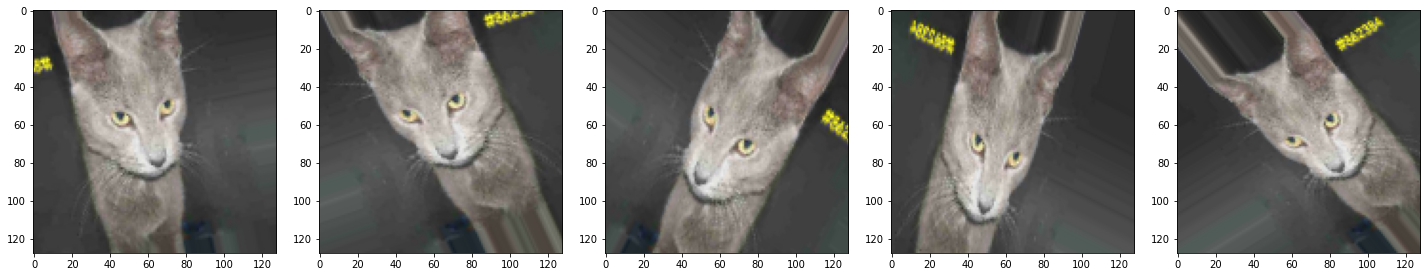

In [9]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [10]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [26]:
URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/4'
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SHAPE, IMG_SHAPE,3))
feature_extractor.trainable = False
model = tf.keras.models.Sequential([
                                    feature_extractor,
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(64,activation='relu'),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(16,activation='relu'),
                                    tf.keras.layers.Dense(2,activation='softmax'),
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)               

In [28]:
model.compile(
              optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',]
              )

In [29]:
epochs = 25
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/25
20/20 [==============================] - 14s 691ms/step - loss: 0.4439 - accuracy: 0.8815 - val_loss: 0.3439 - val_accuracy: 0.9690
Epoch 2/25
20/20 [==============================] - 13s 673ms/step - loss: 0.3775 - accuracy: 0.9340 - val_loss: 0.3384 - val_accuracy: 0.9770
Epoch 3/25
20/20 [==============================] - 13s 666ms/step - loss: 0.3698 - accuracy: 0.9420 - val_loss: 0.3392 - val_accuracy: 0.9730
Epoch 4/25
20/20 [==============================] - 13s 668ms/step - loss: 0.3669 - accuracy: 0.9425 - val_loss: 0.3452 - val_accuracy: 0.9670
Epoch 5/25
20/20 [==============================] - 13s 666ms/step - loss: 0.3674 - accuracy: 0.9410 - val_loss: 0.3375 - val_accuracy: 0.9730
Epoch 6/25
20/20 [==============================] - 14s 675ms/step - loss: 0.3602 - accuracy: 0.9505 - val_loss: 0.3387 - val_accuracy: 0.9740
Epoch 7/25
20/20 [==============================] - 13s 671ms/step - loss: 0.3534 - accuracy: 0.9605 - val_loss: 0.3360 - val_accuracy: 0.9760

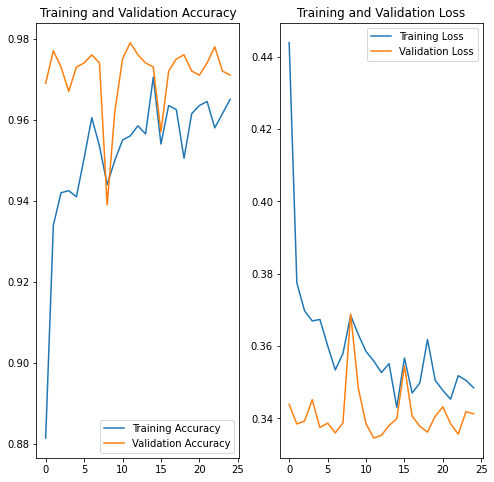

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()